In [2]:
# 使用するパッケージの宣言
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

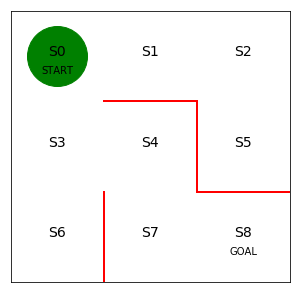

In [3]:
# 初期位置での迷路の様子

# 図を描く大きさと、図の変数名を宣言
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 赤い壁を描く
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 状態を示す文字S0～S8を描く
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 描画範囲の設定と目盛りを消す設定
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 現在地S0に緑丸を描画する
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

# 言葉の定義
## 1. マルコフ決定過程 $( S, A, P, r, \pi, \gamma)$
* 状態集合 $S$
* 行動集合 $A$
* 遷移確率 $P : S \times A \times S \mapsto [0, 1]$ <br>
$ P(s,\ a,\ s') = $ 状態 $s$ で行動 $a$ をとった時に状態 $s'$ に遷移する確率
* 報酬関数 $r : S \times A \times S \mapsto \mathbb{R}$ <br>
$ r(s,\ a,\ s') = $ 状態 $s$で行動 $a$ をとり, 状態 $s'$ に遷移した時にもらえる報酬.
* 方策(政策) $ \pi : S \times A \mapsto [0, 1]$ <br>
$ \pi (s,\ a) = $ 状態 $s$ で行動 $a$ をとる確率.
* 割引率 $\gamma,\ 0 < \gamma < 1$

迷路ゲームの例
* $S = \{ S0,\ S1, \dots,\ S8 \}$
* $A = \{ \text{上},\ \text{下},\ \text{右},\ \text{左} \}$
* $P(S0,\ \text{右},\ S1) = 1,\ P(S0,\ \text{右},\ S2) = 0, \dots $ <br>
迷路ゲームにおいては, 行動に対して次の状態が一意に決まる.
* $r(S7, \text{右}, S8) = 1.0,\ r(S0, \text{右}, S1) = 0.0,\ \dots $ <br>
ゴールについた時に報酬1.0が貰えると定める.それ以外は報酬0

# 迷路ゲーム
最適な方策(政策) $ \pi : S \times A \mapsto [0, 1]$ を求めたい.

つまり, 
$$\pi(S0, \text{下}) \simeq 1,\ \pi(S3, \text{右})  \simeq 1, \pi(S4, \text{下})  \simeq 1,\ \pi(S7, \text{右})  \simeq 1$$
となって4手(最適)でゴールできるように$\pi$を学習したい.

今回は **方策勾配法** を使って$\pi$の学習を行う.


# 方策勾配法

### 1. 方策関数を $\boldsymbol{\theta}$ を用いて定義
$\pi$を媒介変数 $\boldsymbol{\theta} = ( \theta_{(S0, \text{上})},\ \theta_{(S0, \text{下})},\ ,\ \dots \theta_{(S1, \text{上})},\ \dots,\ \theta_{(S7, \text{右})} ) $ を用いて表すことにする.

$$\pi( s_i,\ a_j) = \dfrac{ \exp{ \beta \theta_{( s_i,\ a_j)}} } { \sum_{ k } \exp { \beta \theta_{( s_i,\ a_k)}} }$$

例 :
$$ \pi( S0,\ \text{下} ) = \dfrac{ \exp{ \beta \theta_{( S0,\ \text{下})}} } { \exp{  \beta \theta_{( S0,\ \text{下})}} +\exp{ \beta \theta_{( S0,\ \text{上})}} + \exp{ \beta  \theta_{( S0,\ \text{左})}} + \exp{ \beta \theta_{( S0,\ \text{右})}} } $$

$\beta$は逆温度定数. 温度パラメータをつけることの意味は以下を参照.
https://qiita.com/nkriskeeic/items/db3b4b5e835e63a7f243

またプログラムでは, $\boldsymbol{\theta}$をnumpy行列で表しているけど数学上は <font color="Red">ベクトル</font>
として考えるので注意!!


In [4]:
# 初期の方策を決定するパラメータtheta_0を設定

# 行は状態0～7、列は移動方向で↑、→、↓、←を表す
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8はゴールなので、方策はなし
                    ])

In [5]:
# 方策パラメータthetaを行動方策piにソフトマックス関数で変換する手法の定義


def softmax_convert_into_pi_from_theta(theta):
    '''ソフトマックス関数で割合を計算する'''

    beta = 1.0
    [m, n] = theta.shape  # thetaの行列サイズを取得
    pi = np.zeros((m, n))

    exp_theta = np.exp(beta * theta)  # thetaをexp(theta)へと変換

    for i in range(0, m):
        # pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
        # simpleに割合の計算の場合

        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
        # softmaxで計算の場合

    pi = np.nan_to_num(pi)  # nanを0に変換

    return pi

In [6]:
# 初期の方策pi_0を求める
pi_0 = softmax_convert_into_pi_from_theta(theta_0)
print(pi_0)

[[ 0.          0.5         0.5         0.        ]
 [ 0.          0.5         0.          0.5       ]
 [ 0.          0.          0.5         0.5       ]
 [ 0.33333333  0.33333333  0.33333333  0.        ]
 [ 0.          0.          0.5         0.5       ]
 [ 1.          0.          0.          0.        ]
 [ 1.          0.          0.          0.        ]
 [ 0.5         0.5         0.          0.        ]]


In [7]:
# 行動aと1step移動後の状態sを求める関数を定義


def get_action_and_next_s(pi, s):
    direction = ["up", "right", "down", "left"]
    # pi[s,:]の確率に従って、directionが選択される
    next_direction = np.random.choice(direction, p=pi[s, :])

    if next_direction == "up":
        action = 0
        s_next = s - 3  # 上に移動するときは状態の数字が3小さくなる
    elif next_direction == "right":
        action = 1
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        action = 2
        s_next = s + 3  # 下に移動するときは状態の数字が3大きくなる
    elif next_direction == "left":
        action = 3
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる

    return [action, s_next]

In [8]:
# 迷路を解く関数の定義、状態と行動の履歴を出力


def goal_maze_ret_s_a(pi):
    s = 0  # スタート地点
    s_a_history = [[0, np.nan]]  # エージェントの移動を記録するリスト

    while (1):  # ゴールするまでループ
        [action, next_s] = get_action_and_next_s(pi, s)
        s_a_history[-1][1] = action
        # 現在の状態（つまり一番最後なのでindex=-1）の行動を代入

        s_a_history.append([next_s, np.nan])
        # 次の状態を代入。行動はまだ分からないのでnanにしておく

        if next_s == 8:  # ゴール地点なら終了
            break
        else:
            s = next_s

    return s_a_history

In [9]:
# 初期の方策で迷路を解く
s_a_history = goal_maze_ret_s_a(pi_0)
print(s_a_history)
print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")

[[0, 1], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 1], [2, 3], [1, 3], [0, 1], [1, 3], [0, 1], [1, 1], [2, 3], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 3], [0, 2], [3, 2], [6, 0], [3, 1], [4, 3], [3, 2], [6, 0], [3, 2], [6, 0], [3, 2], [6, 0], [3, 0], [0, 1], [1, 3], [0, 2], [3, 0], [0, 1], [1, 1], [2, 3], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 3], [0, 2], [3, 0], [0, 1], [1, 1], [2, 2], [5, 0], [2, 3], [1, 1], [2, 3], [1, 1], [2, 3], [1, 3], [0, 2], [3, 1], [4, 2], [7, 0], [4, 2], [7, 1], [8, nan]]
迷路を解くのにかかったステップ数は74です


# 方策勾配法

### 2. 更新式の導出

方策 $\pi$ の良さを表す関数 $ J( \boldsymbol{\theta} ) : \mathbb{R}^{ |S| \cdot |A| } \mapsto \mathbb{R}$ を考える.

この時, $J( \boldsymbol{\theta} )$ を最大化するような $\boldsymbol{\theta}$ を最急降下法によって求める.

$$  \boldsymbol{\theta}^{(k+1)} \leftarrow \boldsymbol{\theta}^{(k)} + \eta \nabla J( \boldsymbol{\theta} )  \quad ( \eta : \text{学習率} )$$

最大化したいので, $+$になっていることに注意!!

#### 2.1 $ J( \boldsymbol{\theta} )$ の定義
1. 平均報酬による定義
$$ J( \boldsymbol{\theta} ) = \lim_{n \to \infty} \dfrac{1}{n} \mathbb{E}[ \sum_{t=1}^n r_t ] $$
2. 割引報酬による定義
$$  J( \boldsymbol{\theta} ) = \lim_{n \to \infty} \mathbb{E}[ \sum_{t=1}^n \gamma^{t-1} r_t  ; s_0 ] $$

#### 2.2 方策勾配定理
式変形すると, どちらの定義でも以下のようになる.( 式変形参考 : [book](https://github.com/komi1230/Resume/tree/master/book_reinforcement) p52あたり )
$$ \nabla  J( \boldsymbol{\theta} ) = \mathbb{E}[ Q^{\pi}(s, a) \nabla \log \pi(s,a) ] \quad ( \text{方策勾配定理} ) $$ 

#### 2.3 REINFORCE アルゴリズム
期待値をサンプリングによって近似する. ( $M$ : 試行回数, $T$ : ステップ数, $M$は十分大きいと仮定. )
$$ \nabla  J( \boldsymbol{\theta} ) \simeq \dfrac{1}{M} \sum_{m=1}^{M} \dfrac{1}{T} \sum_{t=1}^{T} Q^{\pi}(s_t, a_t) \nabla \log \pi(s_t,a_t)$$

さらに$Q^{\pi}(s, a)$が未知なので, 収益$R_t$で近似する.
$$ Q^{\pi}(s,a) \simeq R_t = 
\begin{cases} \sum_{k=1}^{T} r_{t+k} \ ( \text{有限エピソードの時はこちらでも良い.} ) \\ 
\sum_{k=1}^{\infty} \gamma^{k-1} r_{t+k} 
\end{cases} $$

( 参考 : [Policy Gradient Methods for Reinforcement Learning with Function Approximation](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf) )

ベースメントを用いて分散を小さくする等の工夫もあるらしい.

最終的に, 
$$
\nabla  J( \boldsymbol{\theta} ) \simeq \dfrac{1}{M} \sum_{m=1}^{M} \dfrac{1}{T} \sum_{t=1}^{T} R_t \nabla \log \pi(s_t,a_t) 
$$

#### 2.4 迷路ゲームの場合の方策勾配法.
ゴールに着いた時にのみ報酬1がもらえるとする.つまり, 
$r_t = \begin{cases} 1 \ ( t = T ) \\ 0 \ ( otherwise ) \end{cases}$
であり, 
$$R_t = \sum_{k=1}^{T} r_{t+k} = 1$$

また, 1エピソードを得るごとに更新しているので, $M = 1$として良い.

方策関数はsoftmax関数で定義していた. 
$$ \pi( s_i,\ a_j) = \dfrac{ \exp{ \beta \theta_{( s_i,\ a_j)}} } { \sum_{ k } \exp { \beta \theta_{( s_i,\ a_k)}} }$$

これらを使って式を変形すると
$$ \nabla  J( \boldsymbol{\theta} ) = 
( \dfrac{ \partial  J( \boldsymbol{\theta} )}{ \partial \theta_{( S0,\ \text{下})}},\ 
\dfrac{ \partial  J( \boldsymbol{\theta} )}{ \partial \theta_{( S0,\ \text{上})}},\ \dots,\ 
\dfrac{ \partial  J( \boldsymbol{\theta} )}{ \partial \theta_{( S7,\ \text{右})}} ) $$

$$ 
\begin{eqnarray}
\dfrac{ \partial  J( \boldsymbol{\theta} )}{ \partial \theta_{(s_i, a_j)}} &\simeq&
\dfrac{1}{T} \sum_{t=1}^T \dfrac{ \partial}{ \partial \theta_{(s_i, a_j)}} ( \log \exp{\beta \theta_{(s_t, a_t)}} - \log \sum_{k=1}^4 \exp{\beta \theta_{(s_t, a_k)}} )  \\
&=& \dfrac{1}{T} ( \sum_{s_t = s_i,\ a_t = a_j} \beta 
- \sum_{s_t = s_i} \dfrac{\beta \exp{\beta \theta_{(s_i, a_j)}}}{\sum_{k=1}^4 \exp{\beta \theta_{(s_i, a_k)}}} )\\
&=& \dfrac{\beta}{T} ( N( s_t = s_i, a_t = a_j) - N(s_t = s_i) \pi(s_i, a_j) )\\
\end{eqnarray}
$$

$\beta = 1.0$より, 書籍の式が求まった.


In [10]:
# thetaの更新関数を定義します

def update_theta(theta, pi, s_a_history):
    eta = 0.1 # 学習率
    T = len(s_a_history) - 1  # ゴールまでの総ステップ数

    [m, n] = theta.shape  # thetaの行列サイズを取得
    delta_theta = theta.copy()  # Δthetaの元を作成、ポインタ参照なので、delta_theta = thetaはダメ

    # delta_thetaを要素ごとに求めます
    for i in range(0, m):
        for j in range(0, n):
            if not(np.isnan(theta[i, j])):  # thetaがnanでない場合

                SA_i = [SA for SA in s_a_history if SA[0] == i]
                # 履歴から状態iのものを取り出すリスト内包表記です

                SA_ij = [SA for SA in s_a_history if SA == [i, j]]
                # 状態iで行動jをしたものを取り出す

                N_i = len(SA_i)  # 状態iで行動した総回数
                N_ij = len(SA_ij)  # 状態iで行動jをとった回数
                
                # 初版では符号の正負に間違いがありました（修正日：180703）
                #delta_theta[i, j] = (N_ij + pi[i, j] * N_i) / T
                delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T

    new_theta = theta + eta * delta_theta

    return new_theta

In [11]:
# 方策の更新
new_theta = update_theta(theta_0, pi_0, s_a_history)
pi = softmax_convert_into_pi_from_theta(new_theta)
print(pi)

[[ 0.          0.50067568  0.49932432  0.        ]
 [ 0.          0.50101351  0.          0.49898649]
 [ 0.          0.          0.50067568  0.49932432]
 [ 0.33333313  0.33288298  0.33378389  0.        ]
 [ 0.          0.          0.50033784  0.49966216]
 [ 1.          0.          0.          0.        ]
 [ 1.          0.          0.          0.        ]
 [ 0.5         0.5         0.          0.        ]]


In [12]:
# 方策勾配法で迷路を解く

# 初版で、def update_thetaに間違いがあった関係で、終了条件を変更します（修正日：180703）
#stop_epsilon = 10**-8  # 10^-8よりも方策に変化が少なくなったら学習終了とする
stop_epsilon = 10**-4  # 10^-4よりも方策に変化が少なくなったら学習終了とする


theta = theta_0
pi = pi_0

is_continue = True
count = 1
while is_continue:  # is_continueがFalseになるまで繰り返す
    s_a_history = goal_maze_ret_s_a(pi)  # 方策πで迷路内を探索した履歴を求める
    new_theta = update_theta(theta, pi, s_a_history)  # パラメータΘを更新
    new_pi = softmax_convert_into_pi_from_theta(new_theta)  # 方策πの更新

    print(np.sum(np.abs(new_pi - pi)))  # 方策の変化を出力
    print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")

    if np.sum(np.abs(new_pi - pi)) < stop_epsilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi

0.00541670554606
迷路を解くのにかかったステップ数は160です
0.015077226479
迷路を解くのにかかったステップ数は14です
0.0190728189432
迷路を解くのにかかったステップ数は14です
0.0174793773541
迷路を解くのにかかったステップ数は28です
0.00761337407905
迷路を解くのにかかったステップ数は48です
0.00667863252666
迷路を解くのにかかったステップ数は84です
0.0106484592195
迷路を解くのにかかったステップ数は30です
0.0240418754623
迷路を解くのにかかったステップ数は8です
0.0232042157241
迷路を解くのにかかったステップ数は8です
0.0188112748663
迷路を解くのにかかったステップ数は10です
0.01212017232
迷路を解くのにかかったステップ数は32です
0.014697185538
迷路を解くのにかかったステップ数は24です
0.0479125730503
迷路を解くのにかかったステップ数は4です
0.0211822118003
迷路を解くのにかかったステップ数は10です
0.00588976920874
迷路を解くのにかかったステップ数は26です
0.00792190011165
迷路を解くのにかかったステップ数は68です
0.00603925827357
迷路を解くのにかかったステップ数は104です
0.00875902152815
迷路を解くのにかかったステップ数は122です
0.0121531661348
迷路を解くのにかかったステップ数は56です
0.0168346977884
迷路を解くのにかかったステップ数は32です
0.0316709818769
迷路を解くのにかかったステップ数は6です
0.0111657538365
迷路を解くのにかかったステップ数は28です
0.00557370838914
迷路を解くのにかかったステップ数は132です
0.00730138735115
迷路を解くのにかかったステップ数は48です
0.0282722718892
迷路を解くのにかかったステップ数は10です
0.0309150968445
迷路を解くのにかかったステップ数は6です
0.005076

0.01820536082
迷路を解くのにかかったステップ数は14です
0.0164064041053
迷路を解くのにかかったステップ数は28です
0.0256111965988
迷路を解くのにかかったステップ数は8です
0.0249900230031
迷路を解くのにかかったステップ数は6です
0.0157305245996
迷路を解くのにかかったステップ数は34です
0.0248876362068
迷路を解くのにかかったステップ数は4です
0.0196489585091
迷路を解くのにかかったステップ数は6です
0.0243927972658
迷路を解くのにかかったステップ数は4です
0.0251657257262
迷路を解くのにかかったステップ数は6です
0.0211848638122
迷路を解くのにかかったステップ数は8です
0.0239699134109
迷路を解くのにかかったステップ数は4です
0.0190435645828
迷路を解くのにかかったステップ数は6です
0.0188812618419
迷路を解くのにかかったステップ数は6です
0.0109030202973
迷路を解くのにかかったステップ数は12です
0.0161027752344
迷路を解くのにかかったステップ数は8です
0.0114298458444
迷路を解くのにかかったステップ数は10です
0.011487441501
迷路を解くのにかかったステップ数は28です
0.014701536691
迷路を解くのにかかったステップ数は10です
0.0207852853544
迷路を解くのにかかったステップ数は8です
0.0226017614867
迷路を解くのにかかったステップ数は8です
0.0159158702177
迷路を解くのにかかったステップ数は8です
0.014963351918
迷路を解くのにかかったステップ数は32です
0.0137500802629
迷路を解くのにかかったステップ数は22です
0.0237124903675
迷路を解くのにかかったステップ数は4です
0.0168000730307
迷路を解くのにかかったステップ数は18です
0.0233729321883
迷路を解くのにかかったステップ数は4です
0.0243657795768
迷路を解くのにかかったステップ数は

迷路を解くのにかかったステップ数は6です
0.011103908626
迷路を解くのにかかったステップ数は6です
0.0122656203057
迷路を解くのにかかったステップ数は8です
0.0074055038774
迷路を解くのにかかったステップ数は4です
0.0126969960908
迷路を解くのにかかったステップ数は10です
0.0115696021088
迷路を解くのにかかったステップ数は8です
0.00746851902252
迷路を解くのにかかったステップ数は4です
0.00738683662873
迷路を解くのにかかったステップ数は4です
0.00730638541978
迷路を解くのにかかったステップ数は4です
0.0072271427365
迷路を解くのにかかったステップ数は4です
0.00714908638777
迷路を解くのにかかったステップ数は4です
0.00707219464075
迷路を解くのにかかったステップ数は4です
0.00826113382914
迷路を解くのにかかったステップ数は8です
0.00704990706415
迷路を解くのにかかったステップ数は4です
0.006974515016
迷路を解くのにかかったステップ数は4です
0.00690023836143
迷路を解くのにかかったステップ数は4です
0.00682705684464
迷路を解くのにかかったステップ数は4です
0.00862287916762
迷路を解くのにかかったステップ数は6です
0.0077229321508
迷路を解くのにかかったステップ数は6です
0.0145113322868
迷路を解くのにかかったステップ数は6です
0.00862120437038
迷路を解くのにかかったステップ数は6です
0.00680127825183
迷路を解くのにかかったステップ数は4です
0.0067297745441
迷路を解くのにかかったステップ数は4です
0.00665931000875
迷路を解くのにかかったステップ数は4です
0.00868984184687
迷路を解くのにかかったステップ数は8です
0.0066405794993
迷路を解くのにかかったステップ数は4です
0.0154878362456
迷路を解くのにかかったステップ数は8です
0.01

迷路を解くのにかかったステップ数は4です
0.00370590900774
迷路を解くのにかかったステップ数は4です
0.00367521296861
迷路を解くのにかかったステップ数は4です
0.00819369099288
迷路を解くのにかかったステップ数は8です
0.00369535150725
迷路を解くのにかかったステップ数は4です
0.00578364606996
迷路を解くのにかかったステップ数は6です
0.00939400615831
迷路を解くのにかかったステップ数は8です
0.00952735311932
迷路を解くのにかかったステップ数は8です
0.00380795125786
迷路を解くのにかかったステップ数は4です
0.00377592587361
迷路を解くのにかかったステップ数は4です
0.00729140470757
迷路を解くのにかかったステップ数は6です
0.00376511107642
迷路を解くのにかかったステップ数は4です
0.00731139427483
迷路を解くのにかかったステップ数は6です
0.0121841372864
迷路を解くのにかかったステップ数は8です
0.00378453792608
迷路を解くのにかかったステップ数は4です
0.00375282084618
迷路を解くのにかかったステップ数は4です
0.00372148259221
迷路を解くのにかかったステップ数は4です
0.00729680667376
迷路を解くのにかかったステップ数は6です
0.00371393902782
迷路を解くのにかかったステップ数は4です
0.00368303414169
迷路を解くのにかかったステップ数は4です
0.00751330133033
迷路を解くのにかかったステップ数は6です
0.0073122545051
迷路を解くのにかかったステップ数は6です
0.00369022178215
迷路を解くのにかかったステップ数は4です
0.00365957392763
迷路を解くのにかかったステップ数は4です
0.00362928987071
迷路を解くのにかかったステップ数は4です
0.00359936412446
迷路を解くのにかかったステップ数は4です
0.0109088676649
迷路を解くのにかかったステップ

0.0021498604698
迷路を解くのにかかったステップ数は4です
0.0021352147398
迷路を解くのにかかったステップ数は4です
0.00577062548715
迷路を解くのにかかったステップ数は6です
0.00215149460877
迷路を解くのにかかったステップ数は4です
0.00213676542373
迷路を解くのにかかったステップ数は4です
0.00212218591981
迷路を解くのにかかったステップ数は4です
0.00210775409542
迷路を解くのにかかったステップ数は4です
0.00209346798186
迷路を解くのにかかったステップ数は4です
0.00504967409619
迷路を解くのにかかったステップ数は6です
0.00208722247899
迷路を解くのにかかったステップ数は4です
0.00207317787479
迷路を解くのにかかったステップ数は4です
0.00844005158914
迷路を解くのにかかったステップ数は6です
0.00206207563468
迷路を解くのにかかったステップ数は4です
0.00568979967802
迷路を解くのにかかったステップ数は6です
0.00207858845432
迷路を解くのにかかったステップ数は4です
0.00206460777445
迷路を解くのにかかったステップ数は4です
0.00205076690158
迷路を解くのにかかったステップ数は4です
0.00203706399183
迷路を解くのにかかったステップ数は4です
0.00202349723127
迷路を解くのにかかったステップ数は4です
0.00201006483536
迷路を解くのにかかったステップ数は4です
0.00199676504838
迷路を解くのにかかったステップ数は4です
0.00198359614292
迷路を解くのにかかったステップ数は4です
0.00197055641927
迷路を解くのにかかったステップ数は4です
0.0044663709827
迷路を解くのにかかったステップ数は6です
0.0124592390991
迷路を解くのにかかったステップ数は8です
0.0019774518078
迷路を解くのにかかったステップ数は4です
0.00196451888945


0.00445943810734
迷路を解くのにかかったステップ数は6です
0.00126054255204
迷路を解くのにかかったステップ数は4です
0.00125383721754
迷路を解くのにかかったステップ数は4です
0.00124718562454
迷路を解くのにかかったステップ数は4です
0.00368619718687
迷路を解くのにかかったステップ数は6です
0.00125224156723
迷路を解くのにかかったステップ数は4です
0.00372753741202
迷路を解くのにかかったステップ数は6です
0.00125780975328
迷路を解くのにかかったステップ数は4です
0.00125114395625
迷路を解くのにかかったステップ数は4です
0.00358051153828
迷路を解くのにかかったステップ数は6です
0.0012572520768
迷路を解くのにかかったステップ数は4です
0.00125059822795
迷路を解くのにかかったステップ数は4です
0.00124399720286
迷路を解くのにかかったステップ数は4です
0.00123744844264
迷路を解くのにかかったステップ数は4です
0.00732646328438
迷路を解くのにかかったステップ数は6です
0.00123717620618
迷路を解くのにかかったステップ数は4です
0.00123070187918
迷路を解くのにかかったステップ数は4です
0.00122427831405
迷路を解くのにかかったステップ数は4です
0.00121790498068
迷路を解くのにかかったステップ数は4です
0.00121158135585
迷路を解くのにかかったステップ数は4です
0.00894276053638
迷路を解くのにかかったステップ数は10です
0.00349848463858
迷路を解くのにかかったステップ数は6です
0.00738992109978
迷路を解くのにかかったステップ数は6です
0.00122849103453
迷路を解くのにかかったステップ数は4です
0.00122214452529
迷路を解くのにかかったステップ数は4です
0.00353900139449
迷路を解くのにかかったステップ数は6です
0.0012215052

迷路を解くのにかかったステップ数は4です
0.000830300641369
迷路を解くのにかかったステップ数は4です
0.000826642046699
迷路を解くのにかかったステップ数は4です
0.000823007995358
迷路を解くのにかかったステップ数は4です
0.000819398264828
迷路を解くのにかかったステップ数は4です
0.000815812635136
迷路を解くのにかかったステップ数は4です
0.0029951240086
迷路を解くのにかかったステップ数は6です
0.000820889000851
迷路を解くのにかかったステップ数は4です
0.000817299734055
迷路を解くのにかかったステップ数は4です
0.000813734312323
迷路を解くのにかかったステップ数は4です
0.000810192521976
迷路を解くのにかかったステップ数は4です
0.000806674151744
迷路を解くのにかかったステップ数は4です
0.0112725035752
迷路を解くのにかかったステップ数は10です
0.000816761017946
迷路を解くのにかかったステップ数は4です
0.000813193602723
迷路を解くのにかかったステップ数は4です
0.000809649892577
迷路を解くのにかかったステップ数は4です
0.0036771839561
迷路を解くのにかかったステップ数は6です
0.000822258691027
迷路を解くのにかかったステップ数は4です
0.00374026013055
迷路を解くのにかかったステップ数は6です
0.0008355345363
迷路を解くのにかかったステップ数は4です
0.00283517553842
迷路を解くのにかかったステップ数は6です
0.000839973149574
迷路を解くのにかかったステップ数は4です
0.000836209494068
迷路を解くのにかかったステップ数は4です
0.000832471645099
迷路を解くのにかかったステップ数は4です
0.000828759362747
迷路を解くのにかかったステップ数は4です
0.00285816179795
迷路を解くのにかかったステップ数は6です
0.000833558067

迷路を解くのにかかったステップ数は4です
0.00257411289401
迷路を解くのにかかったステップ数は6です
0.000582331634777
迷路を解くのにかかったステップ数は4です
0.000580194975766
迷路を解くのにかかったステップ数は4です
0.000578070179184
迷路を解くのにかかったステップ数は4です
0.000575957156494
迷路を解くのにかかったステップ数は4です
0.0024524891517
迷路を解くのにかかったステップ数は6です
0.000580889432588
迷路を解くのにかかったステップ数は4です
0.000578762474938
迷路を解くのにかかったステップ数は4です
0.000576647287378
迷路を解くのにかかったステップ数は4です
0.000574543782472
迷路を解くのにかかったステップ数は4です
0.000572451873595
迷路を解くのにかかったステップ数は4です
0.000570371474933
迷路を解くのにかかったステップ数は4です
0.000568302501468
迷路を解くのにかかったステップ数は4です
0.000566244868973
迷路を解くのにかかったステップ数は4です
0.000564198493998
迷路を解くのにかかったステップ数は4です
0.00583113439561
迷路を解くのにかかったステップ数は6です
0.000566625525454
迷路を解くのにかかったステップ数は4です
0.00583993853702
迷路を解くのにかかったステップ数は6です
0.000569363704948
迷路を解くのにかかったステップ数は4です
0.000567312037363
迷路を解くのにかかったステップ数は4です
0.000565271508062
迷路を解くのにかかったステップ数は4です
0.000563242036053
迷路を解くのにかかったステップ数は4です
0.000561223541086
迷路を解くのにかかったステップ数は4です
0.000559215943642
迷路を解くのにかかったステップ数は4です
0.00055721916492
迷路を解くのにかかったステップ数は4です
0.00055523

0.000408500557017
迷路を解くのにかかったステップ数は4です
0.00184373868174
迷路を解くのにかかったステップ数は6です
0.000409852408218
迷路を解くのにかかったステップ数は4です
0.000408588048157
迷路を解くのにかかったステップ数は4です
0.000407329604842
迷路を解くのにかかったステップ数は4です
0.00535173859372
迷路を解くのにかかったステップ数は6です
0.005362456969
迷路を解くのにかかったステップ数は6です
0.000413784963809
迷路を解くのにかかったステップ数は4です
0.000412508876084
迷路を解くのにかかったステップ数は4です
0.000411238739544
迷路を解くのにかかったステップ数は4です
0.000409974516836
迷路を解くのにかかったステップ数は4です
0.000408716170906
迷路を解くのにかかったステップ数は4です
0.000407463664991
迷路を解くのにかかったステップ数は4です
0.000406216962618
迷路を解くのにかかったステップ数は4です
0.000404976027602
迷路を解くのにかかったステップ数は4です
0.00252519456377
迷路を解くのにかかったステップ数は6です
0.000411667915392
迷路を解くのにかかったステップ数は4です
0.000410394557775
迷路を解くのにかかったステップ数は4です
0.000409127178158
迷路を解くのにかかったステップ数は4です
0.000407865738648
迷路を解くのにかかったステップ数は4です
0.000406610201652
迷路を解くのにかかったステップ数は4です
0.000405360529883
迷路を解くのにかかったステップ数は4です
0.000404116686348
迷路を解くのにかかったステップ数は4です
0.000402878634353
迷路を解くのにかかったステップ数は4です
0.00254949543589
迷路を解くのにかかったステップ数は6です
0.000409817389676
迷路を解くのにかかったステッ

迷路を解くのにかかったステップ数は4です
0.000374261242964
迷路を解くのにかかったステップ数は4です
0.000373142542136
迷路を解くのにかかったステップ数は4です
0.000372028945365
迷路を解くのにかかったステップ数は4です
0.000370920421099
迷路を解くのにかかったステップ数は4です
0.000369816938034
迷路を解くのにかかったステップ数は4です
0.00036871846511
迷路を解くのにかかったステップ数は4です
0.00036762497151
迷路を解くのにかかったステップ数は4です
0.000366536426656
迷路を解くのにかかったステップ数は4です
0.000365452800209
迷路を解くのにかかったステップ数は4です
0.000364374062066
迷路を解くのにかかったステップ数は4です
0.000363300182355
迷路を解くのにかかったステップ数は4です
0.000362231131438
迷路を解くのにかかったステップ数は4です
0.000361166879906
迷路を解くのにかかったステップ数は4です
0.00505443967669
迷路を解くのにかかったステップ数は6です
0.000362949394453
迷路を解くのにかかったステップ数は4です
0.000361885582237
迷路を解くのにかかったステップ数は4です
0.000360826519202
迷路を解くのにかかったステップ数は4です
0.00035977217666
迷路を解くのにかかったステップ数は4です
0.000358722526148
迷路を解くのにかかったステップ数は4です
0.000357677539418
迷路を解くのにかかったステップ数は4です
0.000356637188435
迷路を解くのにかかったステップ数は4です
0.00035560144538
迷路を解くのにかかったステップ数は4です
0.000354570282646
迷路を解くのにかかったステップ数は4です
0.000353543672833
迷路を解くのにかかったステップ数は4です
0.00035252158875
迷路を解くのにかかったステップ数は4です
0.00035150

0.000250696674364
迷路を解くのにかかったステップ数は4です
0.00176202524035
迷路を解くのにかかったステップ数は6です
0.00199778806327
迷路を解くのにかかったステップ数は6です
0.000259017471742
迷路を解くのにかかったステップ数は4です
0.000258369181431
迷路を解くのにかかったステップ数は4です
0.000257723367838
迷路を解くのにかかったステップ数は4です
0.000257080018157
迷路を解くのにかかったステップ数は4です
0.00179375902552
迷路を解くのにかかったステップ数は6です
0.00203874220549
迷路を解くのにかかったステップ数は6です
0.000265749641056
迷路を解くのにかかったステップ数は4です
0.000265072141139
迷路を解くのにかかったステップ数は4です
0.000264397283826
迷路を解くのにかかったステップ数は4です
0.000263725055149
迷路を解くのにかかったステップ数は4です
0.000263055441233
迷路を解くのにかかったステップ数は4です
0.000262388428295
迷路を解くのにかかったステップ数は4です
0.000261724002646
迷路を解くのにかかったステップ数は4です
0.000261062150687
迷路を解くのにかかったステップ数は4です
0.000260402858907
迷路を解くのにかかったステップ数は4です
0.000259746113889
迷路を解くのにかかったステップ数は4です
0.000259091902304
迷路を解くのにかかったステップ数は4です
0.000258440210908
迷路を解くのにかかったステップ数は4です
0.000257791026548
迷路を解くのにかかったステップ数は4です
0.00238481918171
迷路を解くのにかかったステップ数は8です
0.000262675494137
迷路を解くのにかかったステップ数は4です
0.000262009081458
迷路を解くのにかかったステップ数は4です
0.000261345259467
迷路を解くのにかかったス

迷路を解くのにかかったステップ数は4です
0.000231836564802
迷路を解くのにかかったステップ数は4です
0.000231274292562
迷路を解くのにかかったステップ数は4です
0.000230714136178
迷路を解くのにかかったステップ数は4です
0.000230156084719
迷路を解くのにかかったステップ数は4です
0.000229600127328
迷路を解くのにかかったステップ数は4です
0.000229046253217
迷路を解くのにかかったステップ数は4です
0.000228494451673
迷路を解くのにかかったステップ数は4です
0.00148146019611
迷路を解くのにかかったステップ数は6です
0.00023073645366
迷路を解くのにかかったステップ数は4です
0.000230179685247
迷路を解くのにかかったステップ数は4です
0.000229624996434
迷路を解くのにかかったステップ数は4です
0.000229072376581
迷路を解くのにかかったステップ数は4です
0.000228521815118
迷路を解くのにかかったステップ数は4です
0.000227973301544
迷路を解くのにかかったステップ数は4です
0.000227426825427
迷路を解くのにかかったステップ数は4です
0.0130585529826
迷路を解くのにかかったステップ数は20です
0.000227422509429
迷路を解くのにかかったステップ数は4です
0.000226878731757
迷路を解くのにかかったステップ数は4です
0.000226336964852
迷路を解くのにかかったステップ数は4です
0.000225797198533
迷路を解くのにかかったステップ数は4です
0.000225259422687
迷路を解くのにかかったステップ数は4です
0.000224723627268
迷路を解くのにかかったステップ数は4です
0.000224189802291
迷路を解くのにかかったステップ数は4です
0.000223657937838
迷路を解くのにかかったステップ数は4です
0.000223128024053
迷路を解くのにかかったステップ数は4です
0.00022

迷路を解くのにかかったステップ数は4です
0.000188334914455
迷路を解くのにかかったステップ数は4です
0.0136108701305
迷路を解くのにかかったステップ数は18です
0.00117788713562
迷路を解くのにかかったステップ数は6です
0.000189867215528
迷路を解くのにかかったステップ数は4です
0.000189460963561
迷路を解くのにかかったステップ数は4です
0.000189056041989
迷路を解くのにかかったステップ数は4です
0.000188652444887
迷路を解くのにかかったステップ数は4です
0.000188250166364
迷路を解くのにかかったステップ数は4です
0.000187849200566
迷路を解くのにかかったステップ数は4です
0.000187449541665
迷路を解くのにかかったステップ数は4です
0.000187051183873
迷路を解くのにかかったステップ数は4です
0.00018665412143
迷路を解くのにかかったステップ数は4です
0.000186258348613
迷路を解くのにかかったステップ数は4です
0.000185863859724
迷路を解くのにかかったステップ数は4です
0.000185470649105
迷路を解くのにかかったステップ数は4です
0.000185078711124
迷路を解くのにかかったステップ数は4です
0.000184688040183
迷路を解くのにかかったステップ数は4です
0.000184298630715
迷路を解くのにかかったステップ数は4です
0.000183910477184
迷路を解くのにかかったステップ数は4です
0.000183523574085
迷路を解くのにかかったステップ数は4です
0.000183137915943
迷路を解くのにかかったステップ数は4です
0.000182753497315
迷路を解くのにかかったステップ数は4です
0.000182370312787
迷路を解くのにかかったステップ数は4です
0.000181988356975
迷路を解くのにかかったステップ数は4です
0.000181607624526
迷路を解くのにかかったステップ数は4です
0.00018

0.000129298392935
迷路を解くのにかかったステップ数は4です
0.000129073441916
迷路を解くのにかかったステップ数は4です
0.000128849083784
迷路を解くのにかかったステップ数は4です
0.000128625316433
迷路を解くのにかかったステップ数は4です
0.000128402137766
迷路を解くのにかかったステップ数は4です
0.000128179545697
迷路を解くのにかかったステップ数は4です
0.000127957538149
迷路を解くのにかかったステップ数は4です
0.000127736113052
迷路を解くのにかかったステップ数は4です
0.00012751526835
迷路を解くのにかかったステップ数は4です
0.00012729500199
迷路を解くのにかかったステップ数は4です
0.000127075311934
迷路を解くのにかかったステップ数は4です
0.00012685619615
迷路を解くのにかかったステップ数は4です
0.00118835535914
迷路を解くのにかかったステップ数は6です
0.000128393731675
迷路を解くのにかかったステップ数は4です
0.00012817135442
迷路を解くのにかかったステップ数は4です
0.000127949559975
迷路を解くのにかかったステップ数は4です
0.000127728346283
迷路を解くのにかかったステップ数は4です
0.000127507711298
迷路を解くのにかかったステップ数は4です
0.00100604229671
迷路を解くのにかかったステップ数は6です
0.000128374458007
迷路を解くのにかかったステップ数は4です
0.000128152820542
迷路を解くのにかかったステップ数は4です
0.000127931761271
迷路を解くのにかかったステップ数は4です
0.000127711278165
迷路を解くのにかかったステップ数は4です
0.00120662376295
迷路を解くのにかかったステップ数は6です
0.000129311986429
迷路を解くのにかかったステップ数は4です
0.000129088003339
迷路を解くのにかかったステッ

0.000108585802423
迷路を解くのにかかったステップ数は4です
0.000108413608375
迷路を解くのにかかったステップ数は4です
0.000108241826181
迷路を解くのにかかったステップ数は4です
0.000108070454519
迷路を解くのにかかったステップ数は4です
0.000107899492072
迷路を解くのにかかったステップ数は4です
0.00010772893753
迷路を解くのにかかったステップ数は4です
0.000107558789588
迷路を解くのにかかったステップ数は4です
0.000107389046945
迷路を解くのにかかったステップ数は4です
0.000107219708307
迷路を解くのにかかったステップ数は4です
0.000107050772382
迷路を解くのにかかったステップ数は4です
0.000106882237886
迷路を解くのにかかったステップ数は4です
0.00010671410354
迷路を解くのにかかったステップ数は4です
0.000106546368069
迷路を解くのにかかったステップ数は4です
0.000106379030203
迷路を解くのにかかったステップ数は4です
0.00010621208868
迷路を解くのにかかったステップ数は4です
0.000106045542239
迷路を解くのにかかったステップ数は4です
0.000105879389626
迷路を解くのにかかったステップ数は4です
0.000105713629592
迷路を解くのにかかったステップ数は4です
0.000105548260892
迷路を解くのにかかったステップ数は4です
0.000929398750163
迷路を解くのにかかったステップ数は6です
0.0001063564931
迷路を解くのにかかったステップ数は4です
0.000106190075599
迷路を解くのにかかったステップ数は4です
0.000106024050245
迷路を解くのにかかったステップ数は4です
0.000105858415802
迷路を解くのにかかったステップ数は4です
0.000105693171034
迷路を解くのにかかったステップ数は4です
0.000105528314715
迷路を解くのにかかったス

In [13]:
# 最終的な方策を確認
np.set_printoptions(precision=3, suppress=True)  # 有効桁数3、指数表示しないという設定
print(pi)

[[ 0.     0.014  0.986  0.   ]
 [ 0.     0.248  0.     0.752]
 [ 0.     0.     0.427  0.573]
 [ 0.011  0.98   0.009  0.   ]
 [ 0.     0.     0.986  0.014]
 [ 1.     0.     0.     0.   ]
 [ 1.     0.     0.     0.   ]
 [ 0.018  0.982  0.     0.   ]]


In [14]:
# エージェントの移動の様子を可視化します
# 参考URL http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation
from IPython.display import HTML


def init():
    # 背景画像の初期化
    line.set_data([], [])
    return (line,)


def animate(i):
    # フレームごとの描画内容
    state = s_a_history[i][0]  # 現在の場所を描く
    x = (state % 3) + 0.5  # 状態のx座標は、3で割った余り+0.5
    y = 2.5 - int(state / 3)  # y座標は3で割った商を2.5から引く
    line.set_data(x, y)
    return (line,)


#　初期化関数とフレームごとの描画関数を用いて動画を作成
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(
    s_a_history), interval=200, repeat=False)

HTML(anim.to_jshtml())

AttributeError: 'FuncAnimation' object has no attribute 'to_jshtml'